In [1]:
pwd

'/home/vmu/nu_stats'

In [2]:
%cd examples

/home/vmu/nu_stats/examples


In [3]:
%load_ext autoreload
%autoreload 2

# SIM

In [4]:
from astropy import units as u
import numpy as np
from matplotlib import pyplot as plt

In [5]:
import sys
sys.path.append("../")
from nu_stats.simulation import Simulation
from nu_stats.plotting import unit_vectors_skymap as u_v_s

In [6]:
# Simulation parameters
L = 1e48 * (u.erg/u.s)
gamma = 2.2
z = 0.3
atm_flux_norm = 1e-15 * 1/(u.GeV * u.cm**2 * u.s)
Emin = 1e5 * u.GeV
Emax = 1e8 * u.GeV
Enorm = 1e5 * u.GeV

In [7]:
sim = Simulation(L, gamma, z,
    atm_flux_norm = atm_flux_norm,
    Emin=Emin, Emax=Emax, Enorm=Enorm)
sim.run(seed=40)


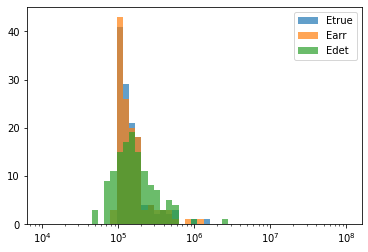

In [8]:
sim.show_spectrum()

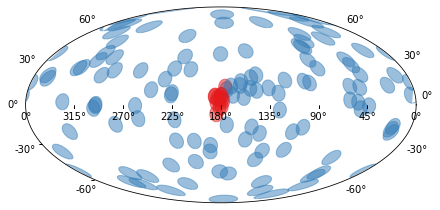

In [9]:
sim.show_skymap()

In [12]:
# Extract simulated data and get info needed for fit
fit_input = sim.get_data()

# FQTIST FIT

In [14]:
from nu_stats.fqutils import FqStructure, plot_loghist

In [20]:
# With energy part
fq = FqStructure(fit_input=fit_input)
fq.construct_atm_bg_energy_likelihood(
    Emin, Emax, n_Esim=100000,
    Nbins=50, prefab_likelihood_file='tmp/atmospheric_50lik.npy'
    )
fq.construct_source_energy_likelihood(
    fit_input['z'], Emin, Emax, min_index=1.5, max_index=4.0, n_Esim=100000,
    Nbins=25, prefab_likelihood_file='tmp/True0.3_25lik.npy'
)

Generating atmospheric background energy likelihood..
Separate marginalized energy likelihood generated for bg.
Generating marginalized energy likelihood..
Marginalized energy likelihood generated.


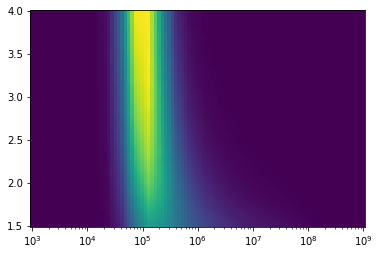

In [21]:
fq.energy_likelihood.plot_pdf_meshgrid();

In [22]:
m, mn_h, mg_h = fq.minimize_neg_lbl()


In [23]:
m.minos()

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 792.6                      │              Nfcn = 186              │
│ EDM = 7.67e-05 (Goal: 0.0001)    │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ n_s   │   14.4    │    3.7    │    -3.4    │    4.0     │    0    │   128   │       │
│ 1 │ gamma │   1.97    │   0.09    │   -0.27    │    0.32    │   1.5   │    4    │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌──────────┬───────────────────────┬───────────────────────┐
│          │          n_s          │         gamma         │
├──────────┼───────────┬───────────┼───────────┬───────────┤
│  Error   │   -3.4    │    4.0    │   -0.27   │   0.32    │
│  Valid   │   True    │   True    │   True    │   True    │
│ At Limit │   False   │   False   │   False   │   False   │
│ Max FCN  │   False   │   False   │   False   │   False   │
│ New Min  │   False   │   False   │   False   │   False   │
└──────────┴───────────┴───────────┴───────────┴───────────┘
┌───────┬─────────────────┐
│       │     n_s   gamma │
├───────┼─────────────────┤
│   n_s │    13.7 0.00385 │
│ gamma │ 0.00385 0.00902 │
└───────┴─────────────────┘

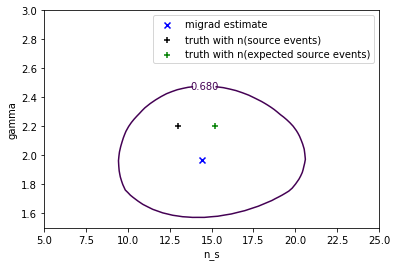

In [25]:
m.draw_mncontour('n_s','gamma')
plt.scatter(mn_h, mg_h, marker='x', c ='b')
plt.scatter(sum(sim.labels==0),sim.truth['gamma'], marker='+', c ='k')
plt.scatter(sim.Nex_ps, sim.truth['gamma'], marker='+', c ='g')
plt.legend(['migrad estimate', 'truth with n(source events)','truth with n(expected source events)'])
plt.xlim((5,25))
plt.ylim((1.5,3.0))
plt.show()

## Individual associations

In [26]:
bg_sim = Simulation(atm_flux_norm=atm_flux_norm, Emin=Emin, Emax=Emax, Enorm=Enorm, N_events=100000)
bg_sim.run(seed=12345678)
bg_dat = bg_sim.get_data()

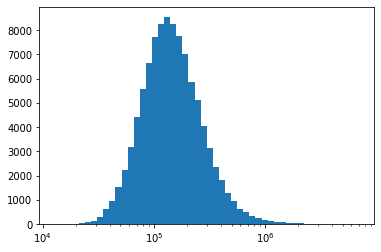

In [27]:
plot_loghist(bg_dat['Edet'], 50);

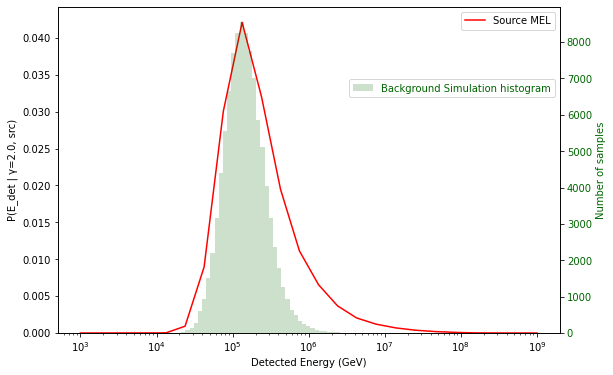

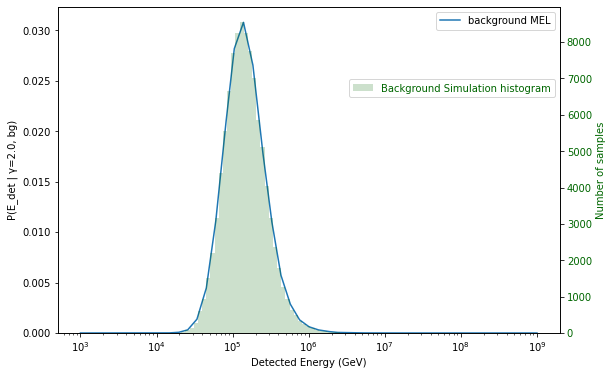

In [33]:
fig, ax = plt.subplots()

fq.energy_likelihood.plot_pdf_at_idx(mg_h, color = 'r')
plt.legend(['Source MEL'], loc='upper right')
ax.set_xlabel('Detected Energy (GeV)')
ax.set_ylabel(f'P(E_det | γ={mg_h:.2}, src)')
ax.set_ylim(0,(ax.get_ylim()[1]))

axh = ax.twinx()

plot_loghist(bg_dat['Edet'],50,color=(0,0.4,0,0.2))
sim_col = (0,0.4,0)
plt.legend(['Background Simulation histogram'],
    loc = 'center right',
    bbox_to_anchor = (0.5, 0.5, 0.5, 0.5),
    labelcolor = sim_col
)
axh.set_ylabel('Number of samples', color=sim_col)
axh.tick_params(axis='y', labelcolor=sim_col)

fig.set_size_inches(*(fig.get_size_inches()*1.5))
fig.show()

fig, ax = plt.subplots()

fq.bg_energy_likelihood.plot_pdf()
plt.legend(['background MEL'], loc='upper right')
ax.set_xlabel('Detected Energy (GeV)')
ax.set_ylabel(f'P(E_det | γ={mg_h:.2}, bg)')
ax.set_ylim(0,(ax.get_ylim()[1]))

axh = ax.twinx()

plot_loghist(bg_dat['Edet'],50,color=(0,0.4,0,0.2))
sim_col = (0,0.4,0)
plt.legend(['Background Simulation histogram'],
    loc = 'center right',
    bbox_to_anchor = (0.5, 0.5, 0.5, 0.5),
    labelcolor = sim_col
)
axh.set_ylabel('Number of samples', color=sim_col)
axh.tick_params(axis='y', labelcolor=sim_col)

fig.set_size_inches(*(fig.get_size_inches()*1.5))
fig.show()


In [35]:
## get p values
sim_TS, bg_TS, sim_p = fq.event_statistics(fit_input, bg_dat, mg_h)
## set label 0 for p<.01 and 1 for p>=.01
labels = (sim_p >=.01).astype(int)

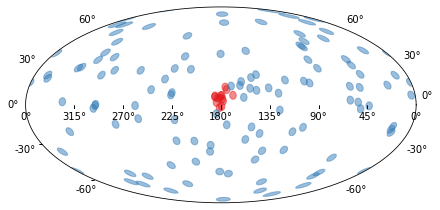

In [36]:
u_v_s(fit_input['det_dir'], labels);

In [37]:
np.mean(labels == sim.labels)

0.9767441860465116

In [39]:
print(f'Source event fraction\nfit: {np.mean(1-labels)}\n\
true: {np.mean(1-sim.labels)}\n\n\
False source events: {np.inner(1-sim.labels, labels)}\n\
False bg events: {np.inner(1-labels, sim.labels)}')

Source event fraction
fit: 0.10852713178294573
true: 0.10077519379844961

False source events: 1
False bg events: 2


In [50]:
bg_TS.sort()

In [51]:
frac = lambda x: np.mean(bg_TS > x)
y = np.array([frac(elem) for elem in bg_TS])

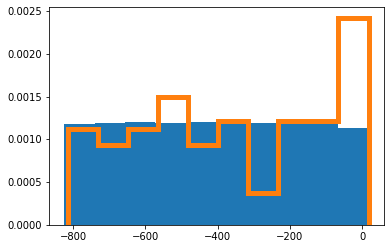

In [47]:
plt.hist(bg_TS,density=True);
plt.hist(sim_TS,histtype='step',linewidth=5,density=True);

# BHM

In [48]:
from nu_stats.bhmutils import BhStructure

In [49]:
bhm = BhStructure(fit_input)
bhm.load_model("stan/bhm_atm.stan")
bhm.run()

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:compiled model file: /home/vmu/nu_stats/examples/stan/bhm_atm
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 1


In [50]:
bhm.print_diagnostic()

INFO:cmdstanpy:Processing csv files: /tmp/tmpq9u7l5m4/bhm_atm-202104301756-1-0agrr2_v.csv, /tmp/tmpq9u7l5m4/bhm_atm-202104301756-2-mhiuh860.csv, /tmp/tmpq9u7l5m4/bhm_atm-202104301756-3-xgyg27h5.csv, /tmp/tmpq9u7l5m4/bhm_atm-202104301756-4-wm968p0p.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory for all transitions.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete, no problems detected.


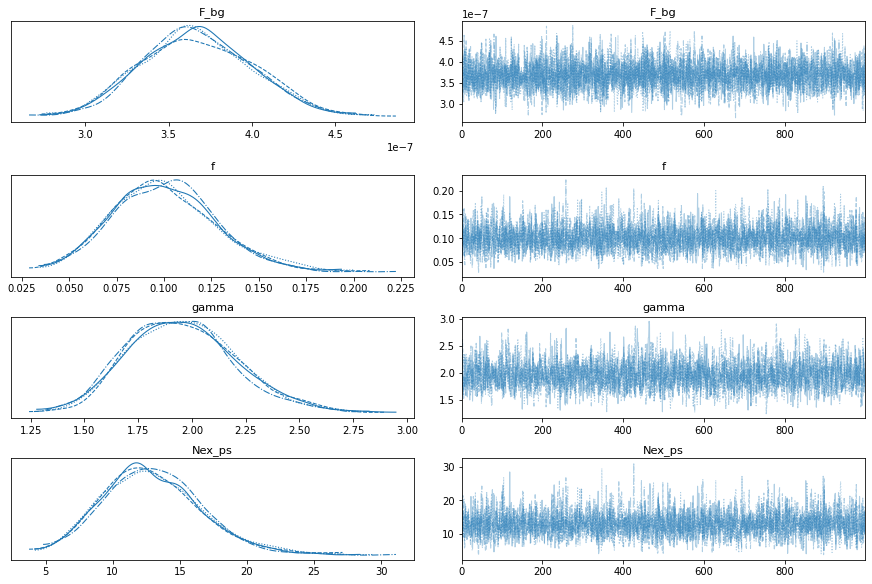

In [51]:
# Trace plot
var_names = ["F_bg", "f", "gamma", "Nex_ps"]
bhm.plot_traces(var_names)


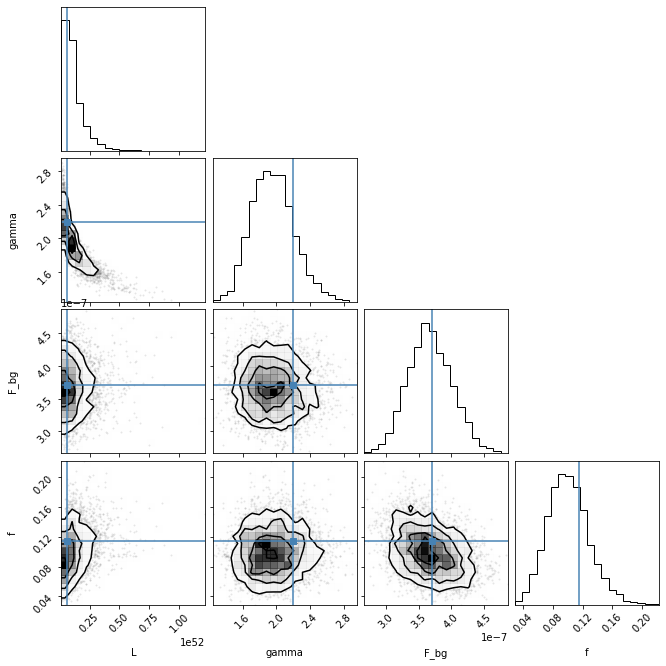

In [52]:
# Corner plot, comparing with truth from sim
var_names = list(sim.truth.keys())
truths_list = [sim.truth[key] for key in var_names]
bhm.plot_corner(var_names, truths_list)

## Individual associations


In [167]:
association = bhm.association_probs()
lp2 = bhm.association_probs(False)

In [168]:
np.intersect1d(association[np.where(association[:,0]>.5)[0],0],
    association[:,0], return_indices=True)[2]

array([ 52,  30, 115,  38,  53,  65, 100, 121,  44,  12,  91,  62,  76])

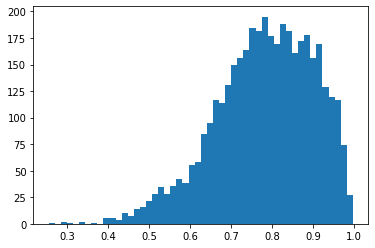

In [169]:
plt.hist(lp2[52,0], bins=50);

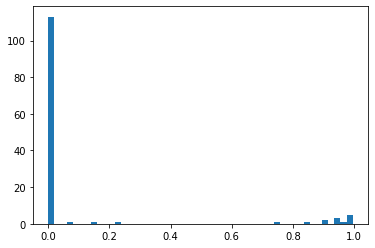

In [170]:
plt.hist(association[:,0], bins=50);

In [142]:
labels_b = 1-(association[:,0] > .5).astype(int)

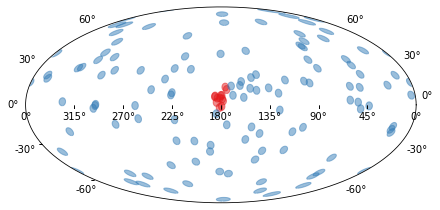

In [138]:
u_v_s(fit_input['det_dir'], labels_b);

In [139]:
np.mean(labels_b == sim.labels)

0.9844961240310077

In [135]:
print(f'Source event fraction\nfit: {np.mean(1-labels_b)}\n\
true: {np.mean(1-sim.labels)}\n\n\
False source events: {np.inner(sim.labels, 1-labels_b)}\n\
False bg events: {np.inner(labels_b, 1-sim.labels)}')

Source event fraction
fit: 0.09302325581395349
true: 0.10077519379844961

False source events: 0
False bg events: 1
